In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from uavsar_pytools.convert.tiff_conversion import read_annotation
from sarxarray import multi_look, complex_coherence

from pathlib import Path

import skgstat as skg

from tqdm import tqdm

from itertools import product

np.random.seed(42)

# home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/')
home_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/')
fig_dir = home_dir.joinpath('figures', 'variograms')

uavsar_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/slc/')

# get list of uavsars directories
uavsars = list(uavsar_dir.glob('*s1_1x1.slc')) # sorted
llh = list(uavsar_dir.glob('*.llh')) # sorted
assert len(llh) == 1
llh = llh[0]


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from itertools import product, combinations
for fp1, fp2 in combinations(uavsars, 2):

    ann1 = pd.DataFrame(read_annotation(fp1.parent.joinpath('_'.join(fp1.stem.split('_')[:8])).with_suffix('.ann')))
    ann2 = pd.DataFrame(read_annotation(fp2.parent.joinpath('_'.join(fp2.stem.split('_')[:8])).with_suffix('.ann')))

    c, r = ann1.loc['value', 'slc_1_1x1_mag.set_cols'], ann1.loc['value', 'slc_1_1x1_mag.set_rows']
    row_dm, col_dm = ann1.loc['value', 'slc_1_1x1_mag.row_mult'], ann1.loc['value', 'slc_1_1x1_mag.col_mult']

    t1, t2 = ann1.loc['value', 'start time of acquisition'], ann2.loc['value', 'start time of acquisition']
    dt = pd.Timedelta(t2 - t1)
    print(dt)
    if abs(dt.days) > 10: continue

    # if you end up needing to geolocate use:
    # Segment 1 Data Approximate Corner 1, Segment 1 Data Approximate Corner 2, Segment 1 Data Approximate Corner 3, Segment 1 Data Approximate Corner 4
    # xyz = np.fromfile(llh, np.float32)
    # lat, long, height = xyz[::2], xyz[1::2], xyz[2::2]
    # lat, long, height = [r.reshape(?, ?) for r in [lat, long, height]]
    
    # coarsen azimuth by 3 so from 0.6 -> 1.8 and leave range as current 1.6 gives use square pixels
    f1 = xr.DataArray(np.fromfile(fp1, dtype = '<c8').reshape(r, c), dims = ['azimuth','range']).coarsen(azimuth = 3, boundary = 'trim').mean().isel(azimuth = slice(0,5000), range = slice(0,5000))# .isel(azimuth = slice(0,20000), range = slice(0,8000))
    f2 = xr.DataArray(np.fromfile(fp2, dtype = '<c8').reshape(r, c), dims = ['azimuth','range']).coarsen(azimuth = 3, boundary = 'trim').mean().isel(azimuth = slice(0,5000), range = slice(0,5000))# .isel(azimuth = slice(0,20000), range = slice(0,8000))
    break

41 days 20:47:40
-343 days +23:27:02
13 days 22:34:19
21 days 01:00:03
-316 days +20:25:04
-355 days +00:09:32
-6 days +22:30:07


In [10]:
def coherence(ref, sec, window = 9):
    den = (ref * ref.conj()).rolling(azimuth = window, range = window).mean() * (sec * sec.conj()).rolling(azimuth = window, range = window).mean()
    num = (ref * sec.conj()).rolling(azimuth = window, range = window).mean()
    return np.abs(num / np.sqrt(den))

In [11]:
# cor = complex_coherence(f1, f2, (100, 100))
cor = coherence(f1, f2)
# cor = xr.DataArray(np.repeat(np.repeat(cor.values, 100, 0), 100, 1), dims = ['azimuth', 'range'])
phase = f1 * f2.conj()
phase = np.rad2deg(np.arctan2(phase.real, phase.imag))#.isel(azimuth = slice(0, int(cor.azimuth.max()) + 1), range = slice(0, int(cor.range.max()) + 1))# .coarsen(range = 5, azimuth = 5, boundary = 'trim').mean()

# ds = xr.merge([cor.rename('cor'), phase.rename('phase')])

In [12]:
ds = xr.merge([cor.rename('cor'), phase.rename('phase')])

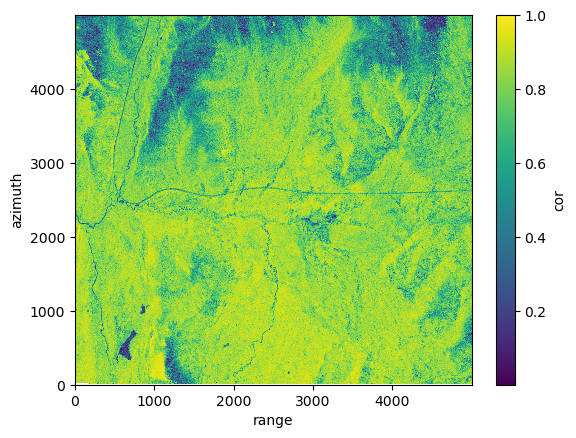

In [13]:
ds['cor'].plot()

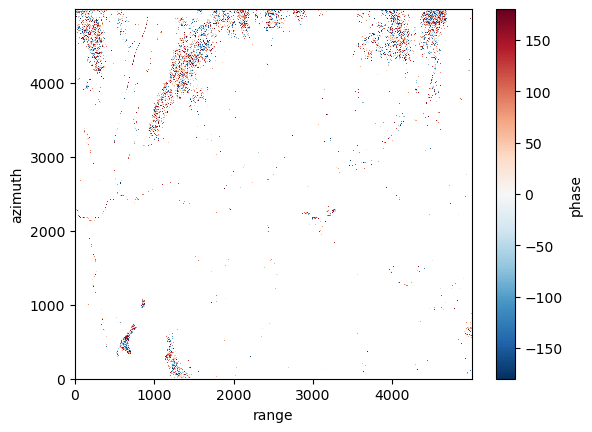

In [17]:
ds['phase'].where((ds['cor'] > 0.0) & (ds['cor'] < 0.4)).plot()

/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


77.64166


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


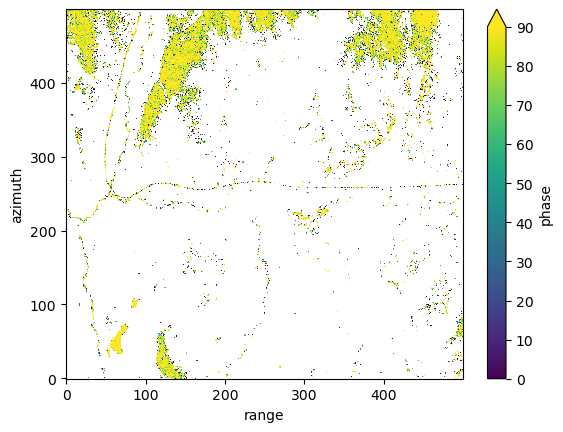

In [18]:
print(ds['phase'].where((ds['cor'] > 0.0) & (ds['cor'] < 0.4)).coarsen(range = 10, azimuth = 10, boundary = 'trim').std().mean().values)
ds['phase'].where((ds['cor'] > 0.0) & (ds['cor'] < 0.4)).coarsen(range = 10, azimuth = 10, boundary = 'trim').std().plot(vmin = 0, vmax = 90)

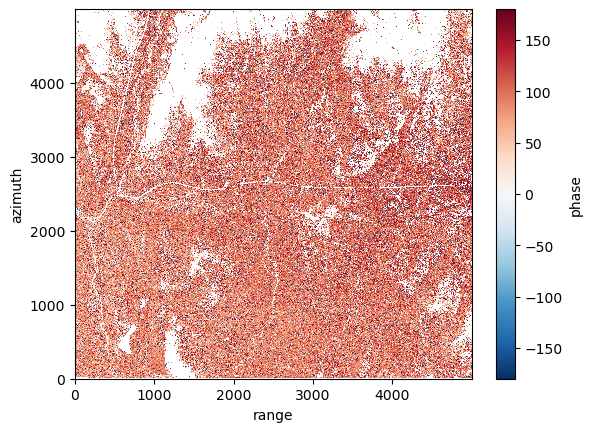

In [19]:
ds['phase'].where((ds['cor'] > 0.7) & (ds['cor'] > 0.7)).plot()

/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


61.880894


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


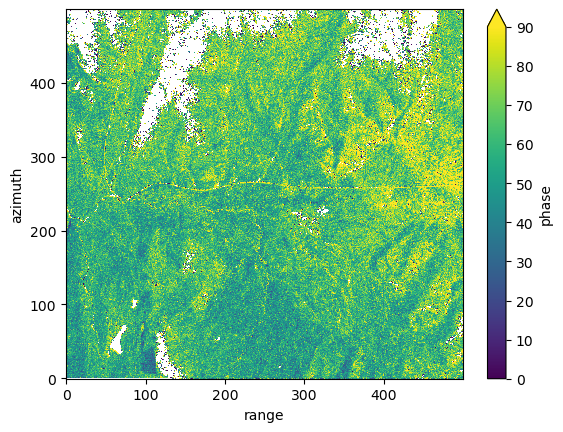

In [20]:
print(ds['phase'].where((ds['cor'] > 0.7) & (ds['cor'] > 0.7)).coarsen(range = 10, azimuth = 10, boundary = 'trim').std(skipna = True).mean().values)
ds['phase'].where((ds['cor'] > 0.7) & (ds['cor'] > 0.7)).coarsen(range = 10, azimuth = 10, boundary = 'trim').std(skipna = True).plot(vmin = 0, vmax = 90)

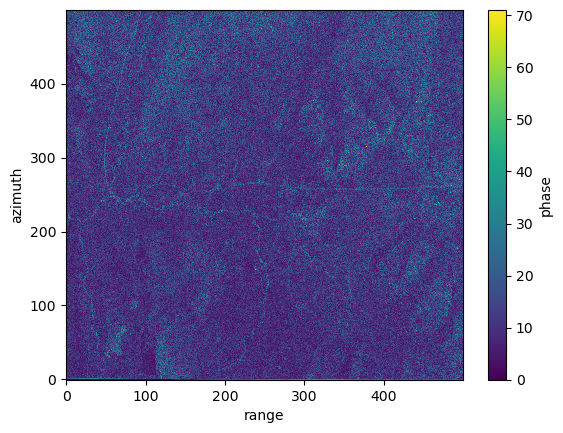

In [21]:
ds['phase'].coarsen(range = 5, azimuth = 5).mean().coarsen(range = 2, azimuth = 2).std().plot()

2
5
10


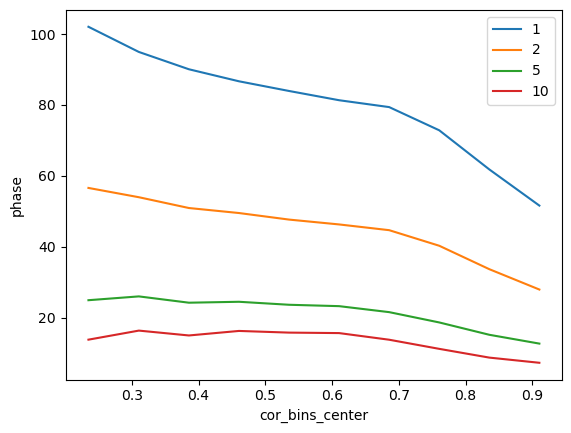

In [14]:
phase = ds['phase'].coarsen(range = int(100), azimuth = int(100)).std()
cor = ds['cor'].coarsen(range = int(100), azimuth = int(100)).mean()
ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
ds_coarsen.groupby_bins('cor', bins = 10).mean()['phase'].plot(label = 1)

for looks in [2,5, 10]:
    print(looks)
    # coarse_ds1 = f1.coarsen(azimuth = looks, range = looks, boundary = 'trim').mean()
    # coarse_ds2 = f2.coarsen(azimuth = looks, range = looks, boundary = 'trim').mean()

    # cor = complex_coherence(coarse_ds1, coarse_ds2, (5, 5))
    # phase = coarse_ds1 * coarse_ds2.conj()
    # phase = np.rad2deg(np.arctan2(phase.real, phase.imag))
    # phase = phase.coarsen(range = 5, azimuth = 5, boundary = 'trim').std()
    # ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
    phase = ds['phase'].coarsen(range = looks, azimuth = looks).mean()
    phase = np.repeat(np.repeat(phase, looks, 0), looks, 1)
    phase = xr.DataArray(phase, dims = ['azimuth', 'range'])
    # phase.plot()
    # plt.show()

    phase = phase.coarsen(range = int(100), azimuth = int(100)).std()
    cor = ds['cor'].coarsen(range = int(100), azimuth = int(100)).mean()
    ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
    ds_coarsen.groupby_bins('cor', bins = 10).mean()['phase'].plot(label = looks)
plt.legend()

2
5
10
20


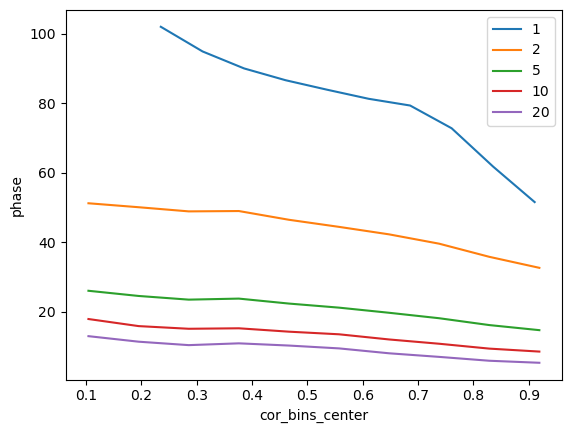

In [15]:
phase = ds['phase'].coarsen(range = int(100), azimuth = int(100)).std()
cor = ds['cor'].coarsen(range = int(100), azimuth = int(100)).mean()
ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
ds_coarsen.groupby_bins('cor', bins = 10).mean()['phase'].plot(label = 1)

for looks in [2,5, 10, 20]:
    print(looks)
    # coarse_ds1 = f1.coarsen(azimuth = looks, range = looks, boundary = 'trim').mean()
    # coarse_ds2 = f2.coarsen(azimuth = looks, range = looks, boundary = 'trim').mean()

    # cor = complex_coherence(coarse_ds1, coarse_ds2, (5, 5))
    # phase = coarse_ds1 * coarse_ds2.conj()
    # phase = np.rad2deg(np.arctan2(phase.real, phase.imag))
    # phase = phase.coarsen(range = 5, azimuth = 5, boundary = 'trim').std()
    # ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
    # ds_coarse = ds.coarsen(range = looks, azimuth = looks).mean()
    # phase = np.repeat(np.repeat(phase, looks, 0), looks, 1)
    # phase = xr.DataArray(phase, dims = ['azimuth', 'range'])
    # phase.plot()
    # plt.show()

    phase = ds['phase'].coarsen(range = looks, azimuth = looks).mean().coarsen(range = int(100/looks), azimuth = int(100/looks)).std()
    cor = ds['cor'].isel(range = slice(0, -1, int(100)), azimuth = slice(0, -1, int(100)))
    ds_coarsen = xr.merge([cor.rename('cor'), phase.rename('phase')])
    ds_coarsen.groupby_bins('cor', bins = 10).mean()['phase'].plot(label = looks)
plt.legend()

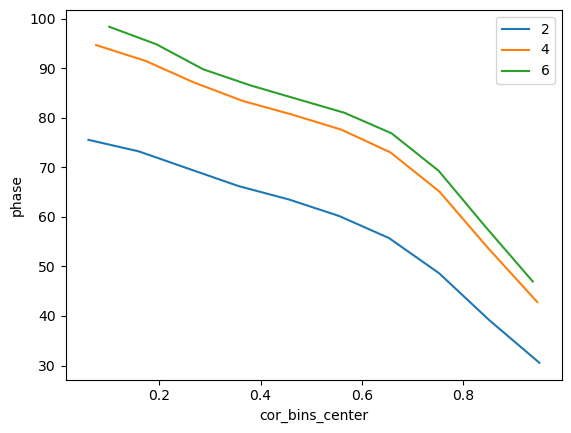

In [16]:
std_phase = ds['phase'].coarsen(range = 20, azimuth = 20, boundary = 'trim').std().copy()
cor_coarsen = ds['cor'].coarsen(azimuth = 20, range = 20, boundary = 'trim').mean().copy()

for looks in 2*np.arange(1, 4):
    std_phase = ds['phase'].coarsen(range = looks, azimuth = looks, boundary = 'trim').std().copy()
    cor_coarsen = ds['cor'].coarsen(azimuth = looks, range = looks, boundary = 'trim').mean().copy()
    ds_coarsen = xr.merge([cor_coarsen.rename('cor'), std_phase.rename('phase')])
    ds_coarsen.groupby_bins('cor', bins = 10).mean()['phase'].plot(label = looks)
plt.legend()

    

In [67]:
cors = {res: np.array([]) for res in [4, 8, 16, 32]}
ints = cors.copy()

for factor, res in zip([ 2, 4, 8, 16], [4, 8, 16, 32]):
    print(res)
    # ref, sec = multi_look(f1, window_size=(factor,factor)), multi_look(f2, window_size=(factor,factor))
    ref, sec = f1, f2

    cor = complex_coherence(ref, sec, (factor, factor))
    phase = ref*sec.conj()
    phase = np.arctan2(phase.real, phase.imag)
    # phase.plot()
    # plt.show()
    phase = phase.coarsen(range = factor, azimuth = factor, boundary = 'trim').std()
    # cor = np.repeat(np.repeat(cor, factor, axis = 0), factor, axis = 1)
    
    cors[res] = np.concatenate([cors[res], cor.values.ravel()])
    ints[res] = np.concatenate([ints[res], phase.values.ravel()])

4


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


8


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


16


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


32


/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


4
8
16
32


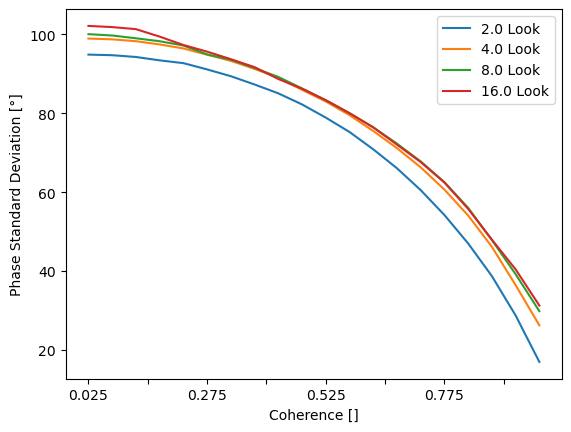

In [70]:
for (res, cor), (res, phase) in zip(cors.items(), ints.items()):
    print(res)
    df = pd.DataFrame(np.vstack([cor, phase]).T, columns = ['cor', 'phase'])
    df = df.dropna()
    df.loc[:, 'bins'] = pd.cut(df.cor, bins = np.arange(0, 1.05, 0.05))
    df["bin_centres"] = df["bins"].apply(lambda x: x.mid)
    # print(df)
    # df = df.loc[df.bin > pd.Interval(0.2, 0.25), :]
    # print(df.groupby('bin_centres')['phase'].mean())
    np.rad2deg(df.groupby('bin_centres')['phase'].mean()).plot(label = f'{res/2} Look')
# plt.xticks(np.arange(0, 1, 0.1))
plt.legend()

plt.xlabel('Coherence []')
plt.ylabel('Phase Standard Deviation [°]')
plt.show()

In [120]:
# locs = []
# cors = {res: np.array([]) for res in ['15', '25', '50', '100']}
# ints = cors.copy()
# for stem, fps in uavsars.copy().items():
#     loc = uavsar.split('_')[0]
#     if loc in locs: continue
#     locs.append(loc)
#     int_fps = [fp for fp in fps if ('.int.' in fp.stem) & ('VV_' in fp.stem)]
#     cor_fps = [fp for fp in fps if ('.cor.' in fp.stem) & ('VV_' in fp.stem)]
#     if len(cor_fps) != 1 and len(int_fps) != 1: continue
#     phase = rxa.open_rasterio(int_fps[0]).squeeze('band', drop = True)
#     phase = np.arctan2(phase.real, phase.imag)
#     cor = rxa.open_rasterio(cor_fps[0]).squeeze('band', drop = True)
#     for factor, res in zip([3, 5, 10, 20], ['15', '25', '50', '100']):
#     # for factor, res in zip([1], ['5']):
#         cors[res] = np.concatenate([cors[res], cor.coarsen(x = factor, y = factor, boundary = 'trim').mean().values.ravel()])
#         ints[res] = np.concatenate([ints[res], phase.coarsen(x = factor, y = factor, boundary = 'trim').std().values.ravel()])
#         # phase.coarsen(x = factor, y = factor, boundary = 'trim').std().plot()
#         # plt.show()
#         # cor.coarsen(x = factor, y = factor, boundary = 'trim').mean().plot()
#         # plt.show()

/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/bsuhome/zacharykeskinen/miniconda3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
